# Support Vector Machines (SVM)

This notebook will demonstrate an application of Support Vector Machines on the [IBMEmployeeAttrition](https://github.com/Madison-Bunting/INDE-577/blob/main/IBMEmployeeAttrition.csv) dataset, first without [principle component analysis](https://github.com/Madison-Bunting/INDE-577/tree/main/unsupervised%20learning/2%20-%20principle%20component%20analysis), then adding it in for comparison.

In [63]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV
import time

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice end formatting
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA

#importing the dataset as a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/Madison-Bunting/INDE-577/main/IBMEmployeeAttrition.csv")

## Pre-Processing
Before we can run SVM, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

First, remove variables with zero variance (as uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook.

In [64]:
#Drop variables with zero variance: EmployeeCount, Over18, and StandardHours
df.drop('EmployeeCount', axis = 1, inplace = True)
df.drop('Over18', axis = 1, inplace = True)
df.drop('StandardHours', axis = 1, inplace = True)

#Replacing Yes/No in the target variable (Attrition) with 1/0
df['Attrition'] = df['Attrition'].map({'No':0, 'Yes':1})

Correlated variables will impact SVM outputs, so those should be dropped as well. As uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook, we should drop Job Level, Total Working Years, Years in Current Role, Years with Current Manager, and Percent Salary Hike.

In [65]:
#Dropping variables listed above that are correlated
df_final = df.drop(['JobLevel','TotalWorkingYears','YearsInCurrentRole', 'YearsWithCurrManager' , 'PercentSalaryHike'], axis=1)
#Confirm those variables were sucessfully dropped
df_final

Index  Age  Attrition     BusinessTravel  DailyRate  \
0         1   41          1      Travel_Rarely       1102   
1         2   49          0  Travel_Frequently        279   
2         3   37          1      Travel_Rarely       1373   
3         4   33          0  Travel_Frequently       1392   
4         5   27          0      Travel_Rarely        591   
...     ...  ...        ...                ...        ...   
1465   1466   36          0  Travel_Frequently        884   
1466   1467   39          0      Travel_Rarely        613   
1467   1468   27          0      Travel_Rarely        155   
1468   1469   49          0  Travel_Frequently       1023   
1469   1470   34          0      Travel_Rarely        628   

                  Department  DistanceFromHome  Education EducationField  \
0                      Sales                 1          2  Life Sciences   
1     Research & Development                 8          1  Life Sciences   
2     Research & Development                 2          2          Other   
3     Research & Development                 3          4  Life Sciences   
4     Research & Development                 2          1        Medical   
...                      ...               ...        ...            ...   
1465  Research & Development                23          2        Medical   
1466  Research & Development                 6          1        Medical   
1467  Research & Development                 4          3  Life Sciences   
1468                   Sales                 2          3        Medical   
1469  Research & Development                 8          3        Medical   

      EmployeeNumber  ...  MonthlyRate NumCompaniesWorked  OverTime  \
0                  1  ...        19479                  8       Yes   
1                  2  ...        24907                  1        No   
2                  4  ...         2396                  6       Yes   
3                  5  ...        23159                  1       Yes   
4                  7  ...        16632                  9        No   
...              ...  ...          ...                ...       ...   
1465            2061  ...        12290                  4        No   
1466            2062  ...        21457                  4        No   
1467            2064  ...         5174                  1       Yes   
1468            2065  ...        13243                  2        No   
1469            2068  ...        10228                  2        No   

      PerformanceRating RelationshipSatisfaction  StockOptionLevel  \
0                     3                        1                 0   
1                     4                        4                 1   
2                     3                        2                 0   
3                     3                        3                 0   
4                     3                        4                 1   
...                 ...                      ...               ...   
1465                  3                        3                 1   
1466                  3                        1                 1   
1467                  4                        2                 1   
1468                  3                        4                 0   
1469                  3                        1                 0   

     TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                        0                1               6   
1                        3                3              10   
2                        3                3               0   
3                        3                3               8   
4                        3                3               2   
...                    ...              ...             ...   
1465                     3                3               5   
1466                     5                3               7   
1467                     0                3               6   
1468                     3          

In [66]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['BusinessTravel'] = le.fit_transform(res_df['BusinessTravel'])
    res_df['Department'] = le.fit_transform(res_df['Department'])
    res_df['Education'] = le.fit_transform(res_df['Education'])
    res_df['EducationField'] = le.fit_transform(res_df['EducationField'])
    res_df['JobRole'] = le.fit_transform(res_df['JobRole'])
    res_df['Gender'] = le.fit_transform(res_df['Gender'])
    res_df['MaritalStatus'] = le.fit_transform(res_df['MaritalStatus'])
    res_df['OverTime'] = le.fit_transform(res_df['OverTime'])
    res_df['Attrition'] = le.fit_transform(res_df['Attrition'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df_final)

The next step is to select which features we want to use with SVM and standardize them.

In [67]:
#Selecting features
X = encoded_df.drop(['Attrition'],axis =1)
y = encoded_df['Attrition']
y

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

In [68]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To apply SVM, the data must be split into "training" and "test" data.

In [69]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [70]:
start = time.time()

#Instantiate the model
svc_default = SVC() # Default hyperparameters
#Fit the model with data
svc_default.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of Default SVM:',svm_time)

y_pred_default = svc_default.predict(X_test)

print('Default Accuracy Score:',accuracy_score(y_test,y_pred_default))

Train Time (seconds) of Default SVM: 0.08562564849853516
Default Accuracy Score: 0.8695652173913043


Next, we want to compare the results using different kernels

In [71]:
start = time.time()

#Linear Kernel
svc_linear = SVC(kernel = 'linear')
#Fit the model with data
svc_linear.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of SVM linear Kernel:',svm_time)

y_pred_linear = svc_linear.predict(X_test)

print('Linear Accuracy Score:',accuracy_score(y_test,y_pred_linear))

Train Time (seconds) of SVM linear Kernel: 0.31902337074279785
Linear Accuracy Score: 0.845108695652174


In [72]:
start = time.time()

#Polynomial Kernel
svc_poly = SVC(kernel = 'poly')
#Fit the model with data
svc_poly.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of SVM with polynomial kernel:',svm_time)

y_pred_poly = svc_poly.predict(X_test)

print('Polynomial Accuracy Score:',accuracy_score(y_test,y_pred_poly))

Train Time (seconds) of SVM with polynomial kernel: 0.0571439266204834
Polynomial Accuracy Score: 0.8559782608695652


In [73]:
start = time.time()

#Radial Kernel
svc_rad = SVC(kernel = 'rbf', probability = True)
#Fit the model with data
svc_rad.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of SVM with radial kernel:',svm_time)

y_pred_rad = svc_rad.predict(X_test)

Train Time (seconds) of SVM with radial kernel: 0.3681049346923828


# Performance Analysis
The next step is to conduct a performance analysis of the model. Because the radial kernel had the highest accuracy in the shortest time, we will only conduct performance analysis using the radial kernel as a predictor. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve. 

In [74]:
print("Accuracy:", accuracy_score(y_test,y_pred_rad))

Accuracy: 0.8695652173913043


Text(0.5, 257.44, 'Predicted label')

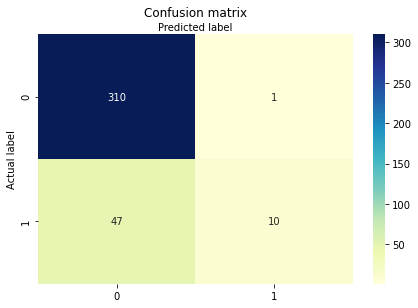

In [75]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rad)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [76]:
#Print a nicely formatted report
classify_svc = classification_report(y_test, y_pred_rad)
print("\nClassification Report")
print(classify_svc)


Classification Report
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       311
           1       0.91      0.18      0.29        57

    accuracy                           0.87       368
   macro avg       0.89      0.59      0.61       368
weighted avg       0.87      0.87      0.83       368



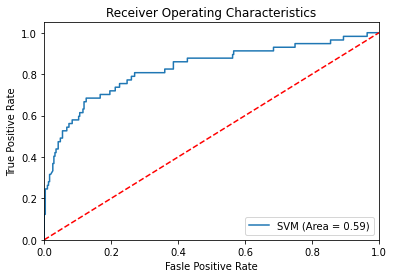

In [77]:
#Plot the ROC curve
svc_roc_auc = roc_auc_score(y_test,y_pred_rad)
fpr, tpr, thresholds = roc_curve(y_test,svc_rad.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='SVM (Area = %0.2f)' % svc_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Fasle Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()

# Using PCA

In [78]:
# Make an instance of the model and specify that 90% of the variance needs to be retained
n = 90
pca = PCA(n/100)

# Fit the PCA on the training set
pca.fit(X_train)

print('To retain',n,'% of the variation, we needed',pca.n_components_,'components')

To retain 90 % of the variation, we needed 21 components


In [79]:
# Applying transformation to both Training and Test set

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [80]:
# SVM with PCA

start = time.time()

svc_pca = SVC(kernel = 'rbf', probability = True)
svc_pca.fit(X_train_pca, y_train)

end = time.time()
svm_time_pca = end-start
print('Train Time (seconds) of SVM with PCA:',svm_time_pca)

y_pred_svc_pca = svc_pca.predict(X_test_pca)

Train Time (seconds) of SVM with PCA: 0.32598328590393066


In [81]:
print("Accuracy:", accuracy_score(y_test,y_pred_svc_pca))

Accuracy: 0.8559782608695652


Text(0.5, 257.44, 'Predicted label')

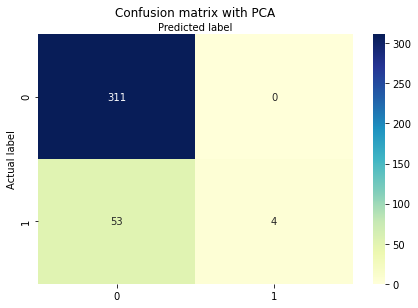

In [82]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svc_pca)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix with PCA', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [83]:
classify_svc_pca = classification_report(y_test, y_pred_svc_pca)
print("\nClassification Report with PCA")
print(classify_svc_pca)


Classification Report with PCA
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       311
           1       1.00      0.07      0.13        57

    accuracy                           0.86       368
   macro avg       0.93      0.54      0.53       368
weighted avg       0.88      0.86      0.80       368



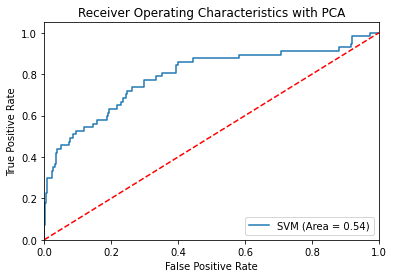

In [84]:
svc_roc_auc_pca = roc_auc_score(y_test,y_pred_svc_pca)
fpr, tpr, thresholds = roc_curve(y_test,svc_pca.predict_proba(X_test_pca)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='SVM (Area = %0.2f)' % svc_roc_auc_pca)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics with PCA')
plt.legend(loc="lower right")
plt.show()

PCA made SVM slightly less accurate, but it also ran slightly faster. See comparison of PCA across algorithms [here](https://github.com/Madison-Bunting/INDE-577/tree/main/unsupervised%20learning/2%20-%20principle%20component%20analysis)